In [11]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd


# path to image directory
image_dir="E:/aerial_cac/train"

# path to csv file where image id's and their corresponding labels are present
csv_dir="E:/aerial_cac/train.csv"

traindf=pd.read_csv(csv_dir,dtype=str)
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null object
dtypes: object(2)
memory usage: 273.6+ KB


In [12]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)


train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=image_dir,
x_col="id",
y_col="has_cactus",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))


valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=image_dir,
x_col="id",
y_col="has_cactus",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))


Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.


In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'E:/weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [14]:
STEP_SIZE_VALID=32
STEP_SIZE_TRAIN=32
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 32 steps
Epoch 1/30
32/32 [==============================] - 51s 2s/step - loss: 0.3958 - acc: 0.8604 - val_loss: 0.4127 - val_acc: 0.7871
Epoch 2/30
32/32 [==============================] - 48s 1s/step - loss: 0.1223 - acc: 0.9531 - val_loss: 0.2303 - val_acc: 0.9004
Epoch 3/30
32/32 [==============================] - 55s 2s/step - loss: 0.0907 - acc: 0.9717 - val_loss: 0.2428 - val_acc: 0.9170
Epoch 4/30
32/32 [==============================] - 50s 2s/step - loss: 0.0563 - acc: 0.9746 - val_loss: 0.1557 - val_acc: 0.9414
Epoch 5/30
32/32 [==============================] - 49s 2s/step - loss: 0.0780 - acc: 0.9707 - val_loss: 0.6647 - val_acc: 0.8086
Epoch 6/30
32/32 [==============================] - 52s 2s/step - loss: 0.0533 - acc: 0.9785 - val_loss: 0.1817 - val_acc: 0.9414
Epoch 7/30
32/32 [==============================] - 53s 2s/step - loss: 0.0399 - acc: 0.9834 - val_loss: 0.1090 - val_acc: 0.964

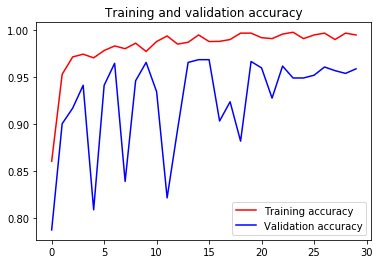

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()